In [1]:
# Library import
library(Seurat)
library(ggplot2)
library(sctransform)
library(harmony)
library(patchwork)
library(dplyr)
library(magrittr)
library(data.table)
library(Matrix)

# Multicore CPU usage activation - Future
library(future)

plan("multicore", workers = 10) 
options(future.globals.maxSize = 12000 * 1024^2)
future.seed=TRUE 

Warning message:
“пакет ‘Seurat’ был собран под R версии 4.3.3”
Загрузка требуемого пакета: SeuratObject

Warning message:
“пакет ‘SeuratObject’ был собран под R версии 4.3.3”
Загрузка требуемого пакета: sp


Присоединяю пакет: ‘SeuratObject’


Следующие объекты скрыты от ‘package:base’:

    intersect, t


Загрузка требуемого пакета: Rcpp

Warning message:
“пакет ‘Rcpp’ был собран под R версии 4.3.3”
Warning message:
“пакет ‘patchwork’ был собран под R версии 4.3.3”

Присоединяю пакет: ‘dplyr’


Следующие объекты скрыты от ‘package:stats’:

    filter, lag


Следующие объекты скрыты от ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“пакет ‘data.table’ был собран под R версии 4.3.3”

Присоединяю пакет: ‘data.table’


Следующие объекты скрыты от ‘package:dplyr’:

    between, first, last


Warning message:
“пакет ‘future’ был собран под R версии 4.3.3”


In [2]:
read_sparse_clonotype <- function(file_path) {
  dt <- fread(file_path, data.table = FALSE)
  rownames(dt) <- dt[, 1]
  dt <- dt[, -1]
  mat <- as(as.matrix(dt), "dgCMatrix")
  return(mat)
}

data_dir_1 <- './SampleTag07_hs_RSEC_MolsPerCell_MEX'
counts_1 <- Read10X(data.dir = data_dir_1)
counts_1_TCR <- read_sparse_clonotype("Group_1_1 Clonotypes.csv")

seurat_object_1 <- CreateSeuratObject(counts = counts_1$`Gene Expression`)
seurat_object_1[["ADT"]] <- CreateAssayObject(counts = counts_1$`Antibody Capture`)
seurat_object_1[["TCR"]] <- CreateAssayObject(counts = t(counts_1_TCR))  # transpose: features as rows

data_dir_2 <- './SampleTag10_hs_RSEC_MolsPerCell_MEX'
counts_2 <- Read10X(data.dir = data_dir_2)
counts_2_TCR <- read_sparse_clonotype("Group_1_2 Clonotypes.csv")

seurat_object_2 <- CreateSeuratObject(counts = counts_2$`Gene Expression`)
seurat_object_2[["ADT"]] <- CreateAssayObject(counts = counts_2$`Antibody Capture`)
seurat_object_2[["TCR"]] <- CreateAssayObject(counts = t(counts_2_TCR))

10X data contains more than one type and is being returned as a list containing matrices of each type.

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have pipe characters ('|'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have pipe characters ('|'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
10X data contains more than one type and is being returned as a list containing matrices of each type.

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have unde

In [3]:
# Merge samples
merged_seurat <- merge(seurat_object_1, y = seurat_object_2, 
                       add.cell.ids = c("Sample_1",
                                        "Sample_2"), 
                       project = "TCRscape")

# Split by sample
merged_seurat[['Sample']] = as.character(sapply(
    rownames(merged_seurat@meta.data), function(x) {strsplit(x,"_")[[1]][[2]]}))
merged_seurat

An object of class Seurat 
16586 features across 8398 samples within 3 assays 
Active assay: RNA (384 features, 0 variable features)
 2 layers present: counts.1, counts.2
 2 other assays present: ADT, TCR

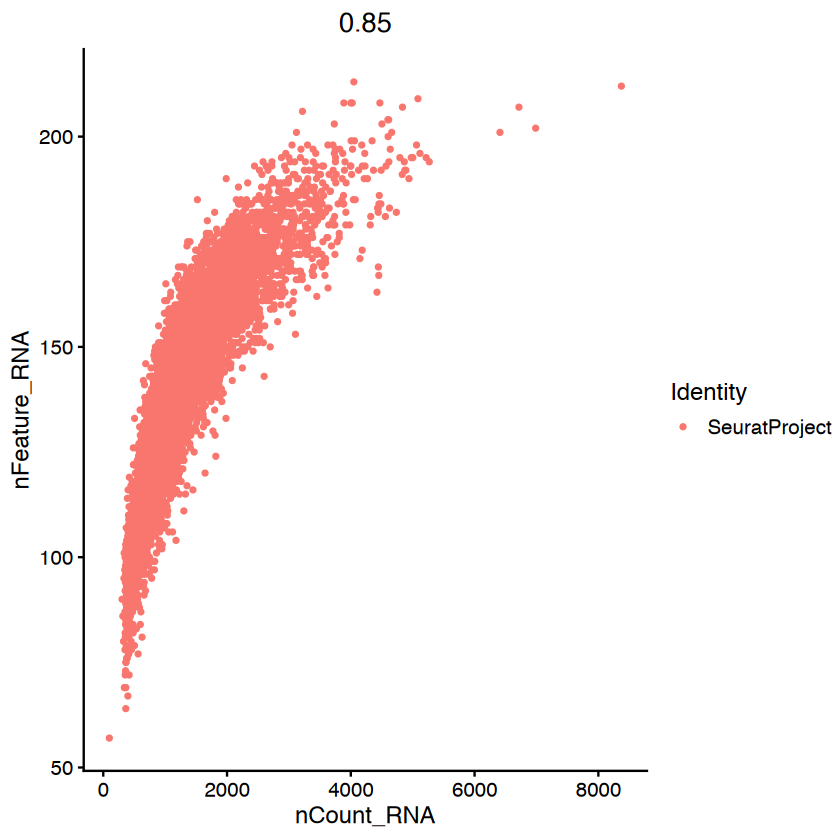

In [5]:
# FeatureScatter Plot QC

# FeatureScatter(merged_seurat, feature1 = "nCount_RNA", feature2 = "percent.mt")
FeatureScatter(merged_seurat, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")

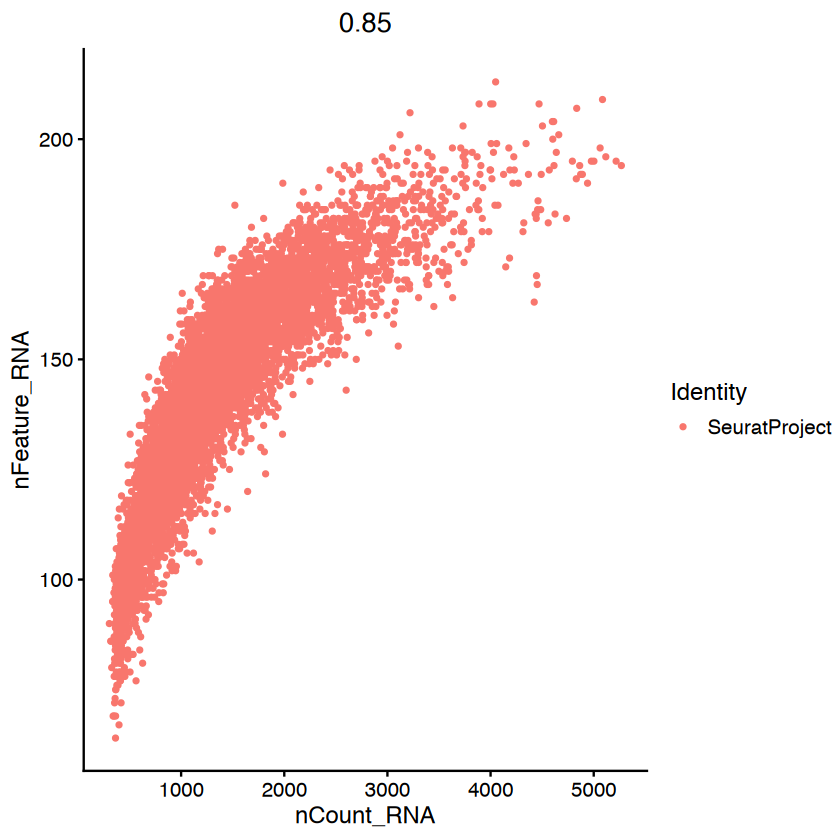

In [19]:
merged_seurat_QC <- subset(merged_seurat, subset = 
                           nCount_RNA > 100 
                           & nCount_RNA < 6000
                           # & percent.mt < 20
                          )
# FeatureScatter(merged_seurat_QC, feature1 = "nCount_RNA", feature2 = "percent.mt")
FeatureScatter(merged_seurat_QC, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")

In [20]:
SCT_merged_seurat <- SCTransform(merged_seurat_QC,
                                # vars.to.regress = "percent.mt", 
                                 verbose = FALSE)
SCT_merged_seurat <- RunPCA(SCT_merged_seurat, npcs = 40, verbose = FALSE)

In [34]:
harmonized_seurat <- IntegrateLayers(
  object = SCT_merged_seurat,
# The following integration method functions are available:
  method = HarmonyIntegration, 
# method = CCAIntegration,
# method = JointPCAIntegration,
# method = RPCAIntegration,
  normalization.method = "SCT",
  verbose = F
)

Warning message:
“HarmonyMatrix is deprecated and will be removed in the future from the API in the future”


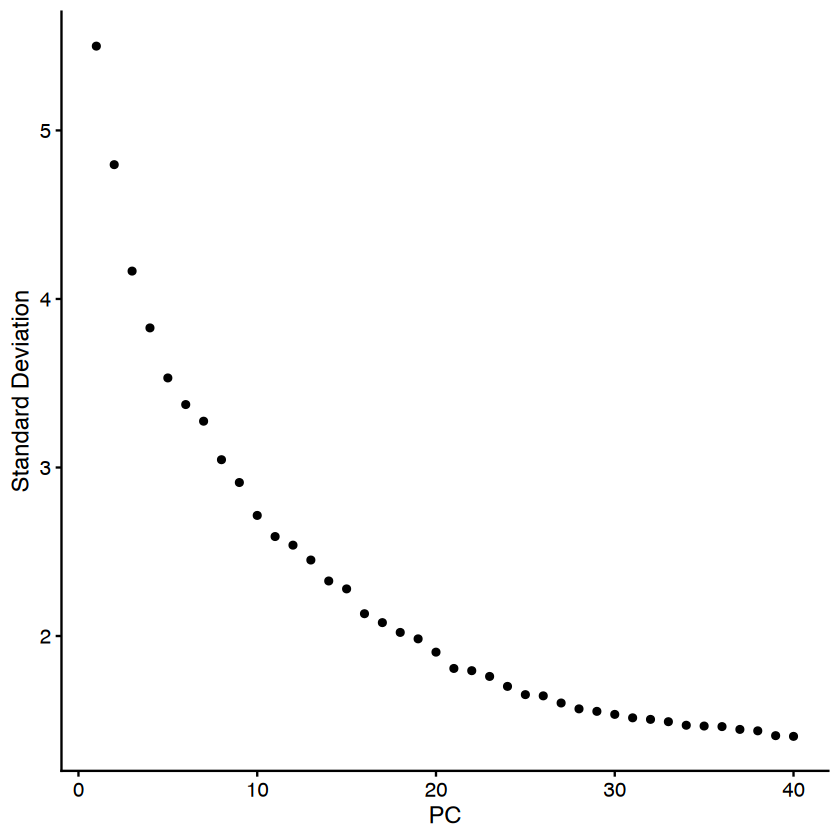

In [35]:
ElbowPlot(harmonized_seurat, ndims = 40, reduction = "pca")

In [36]:
dims = 30 

harmonized_seurat <- FindNeighbors(harmonized_seurat, dims = 1:dims, reduction = "harmony")
harmonized_seurat <- FindClusters(harmonized_seurat, resolution = 0.5)
harmonized_seurat <- RunUMAP(harmonized_seurat, dims = 1:dims, reduction = "harmony")
harmonized_seurat <- PrepSCTFindMarkers(harmonized_seurat, assay = "SCT", verbose = TRUE)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8393
Number of edges: 294244

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8179
Number of communities: 14
Elapsed time: 0 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”
18:34:09 UMAP embedding parameters a = 0.9922 b = 1.112

В кеше найдено больше одного класса "dist"; использую первый, из пространства имен 'spam'

Также определен в ‘BiocGenerics’

18:34:09 Read 8393 rows and found 30 numeric columns

18:34:09 Using Annoy for neighbor search, n_neighbors = 30

В кеше найдено больше одного класса "dist"; использую первый, из пространства имен 'spam'

Также определен в ‘BiocGenerics’

18:34:09 Building Annoy index with metric = cosine, n_trees = 50

0%   10   

[[1]]


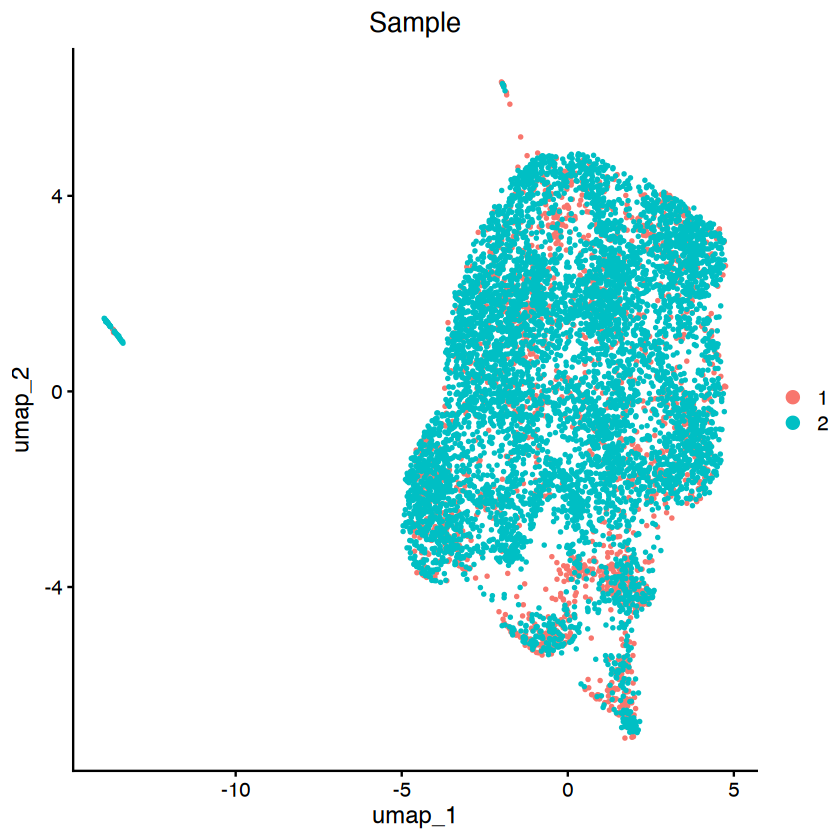

In [37]:
DimPlot(
  harmonized_seurat,
  reduction = "umap",
  group.by = c("Sample"),
  combine = FALSE, 
  pt.size = 0.5, label.size = 0.25
)

ggsave(
  "Cluster QC.pdf",
  plot = last_plot(),
  device = "pdf",
#   path = NULL,
#   scale = 1,
#   1 plot == 10 cm in each dimention
  width = 16.,
  height = 15,
  units = "cm",
  dpi = 10000,
  limitsize = TRUE
)

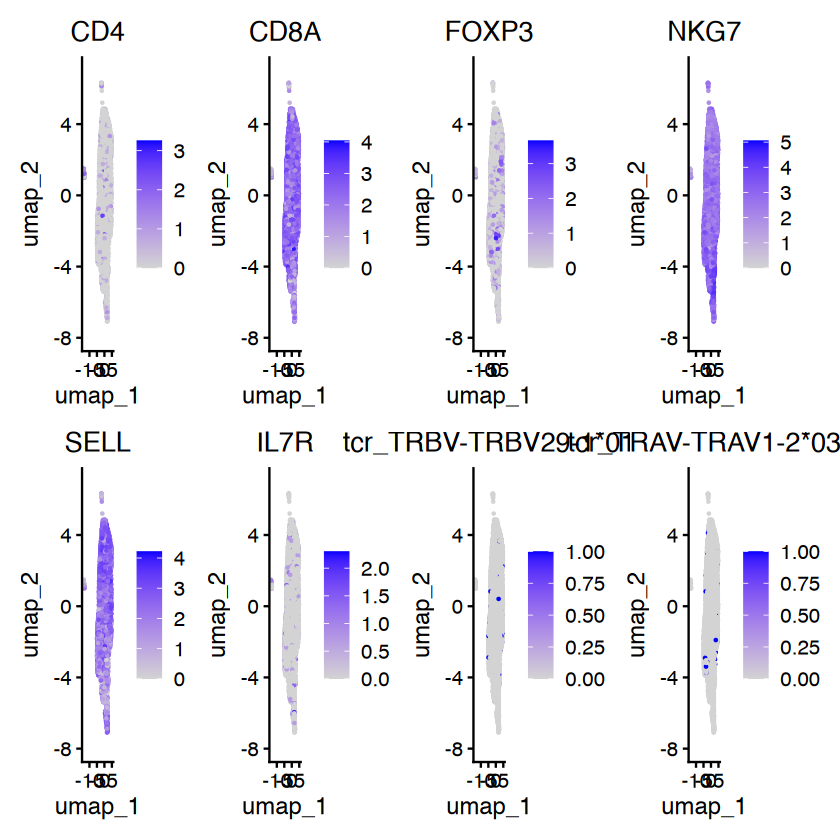

In [61]:
DefaultAssay(harmonized_seurat) <- 'SCT'
FeaturePlot(harmonized_seurat, features = c('CD4','CD8A','FOXP3','NKG7','SELL','IL7R'
                                            ,'tcr_TRBV-TRBV29-1*01'
                                            ,'tcr_TRAV-TRAV1-2*03'
                                           ), 
                  reduction = 'umap', ncol = 4, pt.size = 0.25)

ggsave(
  "T-cell Markers.pdf",
  plot = last_plot(),
  device = "pdf",
  width = 43.5,
  height = 20,
  units = "cm",
  dpi = 10000,
  limitsize = TRUE
)